# Step 6: Temporal simulation of the occupational data

*AIM:* Explores the temporal dimension and runs temporal simulation of the occupational data.

References:

1) `Monte Carlo methods: Crema ER. Modelling Temporal Uncertainty in Archaeological Analysis. J Archaeol Method Theory. 2012;19: 440–461.`

2) `Kaše V. tempun. Zenodo; 2021.`

3) `Kaše, V., Sobotková, A., Heřmánková, P. (2023). Modeling Temporal Uncertainty in Historical Datasets. Proceedings of the Conference on Computational Humanities Research 2023. CEUR xxx, xx-xx`

4) `Waltzing JP. Étude historique sur les corporations professionnelles chez les Romains depuis les origines jusqu’à la chute de l’Empire d’Occident. Louvain: C. Peeters; 1895.`

5) `Petrikovits H v. Die Spezialisierung des römischen Handwerks. Handw Vor- Frühgesch Zeit 1 Hist Rechtshistorische Beitr Untersuchungen Zur Frühgesch Gilde Ber Über Kolloquien Komm Für Altertumskunde Mittel- Nordeur Den Jahren 1977 Bis 1980. 1981; 63–132.`

6) `Harris EM. Workshop, Marketplace and Household: The Nature of Technical Specialization in Classical Athens and its Influence on Economy and Society. In: Carledge P, Cohen EE, Foxhall L, editors. Money, Labour and Land: Approaches to the Economy of Ancient Greece. London—New York: Routledge; 2001. pp. 67–99.`

to do:

go through, comment, run


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

## Data:

### IN:

1) Inscriptions with occupational data `LIST_occupsorgs_industry.parquet` 

CONTINUE



### OUT: 

1) Inscriptions with occupational data and random dates `LIST_occupsorgs_temporal.parquet`

# Requirements

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import nltk

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
#import proplot as plot
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
#from gensim import corpora
import seaborn as sns
#import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
# but you can have yours stored locally on your computer and read it in directly
s = sddk.cloudSession("sciencedata.dk", ".", "648560@au.dk")
figpath = "./PSNP_shared/lat_socdiv/"

Your ScienceData username (e.g. '123456@au.dk'): 648560@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/./


In [3]:
# global parameters for plots
plt.style.use("seaborn-white")
#plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".svg")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

## Import the dataset

In [4]:
# read local version:
LIST_all = gpd.read_parquet("../../data/large_data/LIST_occupsorgs_industry.parquet")
LIST_all.head(3)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups_cats
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,"[22.719769, 37.631278]",10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21,rural,[]
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[]
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,"[22.726044, 37.9799]",63682.52,24,"[22.044647, 37.885611]",40453.51,6,"[22.081952, 38.252707]",497.57,small,[]


In [5]:
# testing consistency of the data
def try_eval(cell_value):
    try: return eval(cell_value)
    except: return cell_value
for col in LIST_all.columns:
    LIST_all[col] = LIST_all[col].apply(try_eval)

In [6]:
# testing consistency of the data

def proper_nones(type_value):
    if not isinstance(type_value, str):
        type_value = None
    return type_value

LIST_all["type_of_inscription_auto"] = LIST_all["type_of_inscription_auto"].apply(proper_nones)

# Temporal simulations

In [5]:
# limit to inscriptions with temporal data only

LIST = LIST_all[(LIST_all["not_before"].notnull()) | (LIST_all["not_after"].notnull())]
len(LIST)

203877

## Generating random dates

In [6]:
%%time
# generate a list of 100 random dates for each inscription in the dataset

LIST["random_dates"] = LIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100, seed=row.name), axis=1)

CPU times: user 1min 2s, sys: 533 ms, total: 1min 2s
Wall time: 1min 2s


In [7]:
LIST.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups_cats,random_dates
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21,rural,[],"[-68, -68, -68, -68, -68, -68, -68, -68, -68, ..."
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],"[311, 312, 309, 310, 310, 309, 310, 310, 311, ..."
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,63682.52,24,"[22.044647, 37.885611]",40453.51,6,"[22.081952, 38.252707]",497.57,small,[],"[-74, -74, -74, -74, -74, -74, -74, -74, -74, ..."
3,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,471.49,55,"[22.405305, 37.642803]",23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],"[279, 280, 278, 279, 281, 281, 277, 277, 276, ..."
4,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,2997.22,55,"[22.405305, 37.642803]",20944.51,73,"[22.336587, 37.462155]",7505.76,large,[],"[50, 50, 50, 50, 50, 49, 50, 49, 49, 49, 50, 4..."


In [8]:
# saving the dataset with random dates locally (in case computer crashes)

LIST.to_parquet("../../data/large_data/LIST_occupsorgs_temporal.parquet")

In [ ]:
# read local version:
LIST = gpd.read_parquet("../../data/large_data/LIST_occupsorgs_temporal.parquet")

## Temporal simulation by timeblocks

In [20]:
%%time
LIST_complete_simulations = tempun.timeblocks_from_randoms(LIST, "random_dates", [-200, 600, 50])

KeyError: None

In [21]:
LIST_complete_simulations[0]

NameError: name 'LIST_complete_simulations' is not defined

In [22]:
LIST_complete_merged = tempun.simulations_merged(LIST_complete_simulations)

NameError: name 'LIST_complete_simulations' is not defined

In [10]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Late Republic" : {"startdate": -200, "enddate" : -26},
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Military emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337},
    "Late Antiquity" : {"startdate" : 338, "enddate" : 600}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-200, -26),
 (-27, 68),
 (69, 96),
 (97, 192),
 (193, 235),
 (236, 284),
 (285, 337),
 (338, 600)]

# Overview of occupations and organizations over time

In [13]:
var_data_occups = []
for var_n in range(100):
    var_data_occups.append([var[var_n] for var in LIST[LIST["occups_N"] > 0]["random_dates"] if var !=None])

In [14]:
print(len(var_data_occups[0]))

5745


In [15]:
%%time
var_data_lire = []
for var_n in range(100):
    var_data_lire.append([var[var_n] for var in LIST["random_dates"] if var !=None])

CPU times: user 3.64 s, sys: 55.5 ms, total: 3.69 s
Wall time: 3.69 s


In [16]:
sample_size = len(var_data_occups[0]) # + len(var_data_orgs[0])
sample_size

5745

In [17]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

In [ ]:
%%time 
# timeconsuming, because of the KDE involved

n_sim = 100

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[5.2, 3], tight_layout=True)

for period, color in zip(periods.keys(), colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_lire[:n_sim]:
    # to be based on sample or not... 
    data = random.sample(data, k=sample_size)
    sns.kdeplot(data, ax=ax, color="black") #, alpha=0.5)   
    
for data in var_data_occups[:n_sim]:
    sns.kdeplot(data, ax=ax, color="darkgreen") #, alpha=0.5)

ax.set_xlim(-200,600)

ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")


markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkgreen", "darkblue"]]
plt.legend(markers, ["Ins. - random\nsample (N={0})".format(str(sample_size)), "Ins. mentioning\noccupations", "Ins. mentioning\norganizations"], bbox_to_anchor=(1, 1), loc='upper left')


In [ ]:
save_figure(fig, "occups_vs_sample_tempdist_kde")

## Compare temporal distributions of occupations by urban contexts

In [ ]:
def get_vars(df_whole, context, n_sim=1000):
    df_context = df_whole[df_whole["urban_context_alt"]==context]
    df_context_occup = df_context[df_context["occups_N"]>0]
    type_dict = dict(df_context_occup.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    var_data_context, var_data_context_control, tb_data, tb_data_control = [], [], [], []
    timeblocks = tempun.get_timeblocks(-50, 350, 50)
    for var_n in range(n_sim):
        var_data = [var[var_n] for var in df_context_occup["random_dates"] if var !=None]
        var_data_context.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        df_sample = pd.DataFrame()
        for key in type_dict.keys():
            if isinstance(key, float): # if nan
                df_type = df_context[df_context["type_of_inscription_auto"].isnull()].sample(type_dict[key], random_state=var_n)
            else:
                df_type = df_context[df_context["type_of_inscription_auto"]==key].sample(type_dict[key], random_state=var_n)
            df_sample = pd.concat([df_sample, df_type])
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_context_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_context, var_data_context_control, tb_data, tb_data_control

In [ ]:
%%time
var_data_large, var_data_large_control, tb_data_large, tb_data_large_control = get_vars(LIST, "large", 1000)
var_data_medium, var_data_medium_control, tb_data_medium, tb_data_medium_control = get_vars(LIST, "medium", 1000)
var_data_small, var_data_small_control, tb_data_small, tb_data_small_control = get_vars(LIST, "small", 1000)
var_data_rural, var_data_rural_control, tb_data_rural, tb_data_rural_control = get_vars(LIST, "rural", 1000)

In [ ]:
%%time
# timeconsuming, because of the KDE involved
n_sims = 1000
ylim_val = 0.0065

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]
#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1, figsize=[5.2, 4.4], tight_layout=True)

### ax1 - large
for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()

for data in var_data_large_control[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="black", alpha=0.5)
for data in var_data_large[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="darkred", alpha=0.5)

ax1.set_xlim(-50,350)
ax1.set_ylabel("KDE")
ax1.set_ylim(0, ylim_val)

### ax2 - medium
for period, color in zip(periods.keys(), colors_list):
    ax2.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")

for data in var_data_medium_control[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="black", alpha=0.5)
for data in var_data_medium[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="darkgreen", alpha=0.5)

ax2.set_xlim(-50,350)
ax2.set_ylabel("KDE")
ax2.set_ylim(0, ylim_val)
ax2.set_xticks([])

### ax3 - small
for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_small_control[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="black", alpha=0.5)
for data in var_data_small[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="darkblue", alpha=0.5)
ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
ax3.set_ylim(0, ylim_val)
ax3.set_xticks([])

### ax4 - rural
for period, color in zip(periods.keys(), colors_list):
    ax4.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_rural_control[:n_sims]:
    sns.kdeplot(data, ax=ax4, color="black", alpha=0.5)
for data in var_data_rural[:n_sims]:
    sns.kdeplot(data, ax=ax4, color="purple", alpha=0.5)
ax4.set_xlim(-50,350)
ax4.set_ylabel("KDE")
ax4.set_ylim(0, ylim_val)

ax1.set_title("A", x=0.025, y=0.65)
ax2.set_title("B", x=0.025, y=0.65)
ax3.set_title("C", x=0.025, y=0.65)
ax4.set_title("D", x=0.025, y=0.65)

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkred", "darkgreen", "darkblue", "purple"]]
ax1.legend(markers, ["Random sample", "Occups. large cities", "Occups. medium cities", "Occups. small cities", "Occups. rural areas"], bbox_to_anchor=(1, 1.4), loc='upper left')

In [ ]:
save_figure(fig, "occups_vs_sample_by_context_tempdist_kde")

In [ ]:
LIST_large = LIST[LIST["urban_context_alt"]=="large"]

In [ ]:
len(LIST_large[LIST_large["occups_N"]>0])

In [ ]:
len(LIST_large[(LIST_large["occups_N"]>0) & (LIST_large["type_of_inscription_auto"]=="epitaph")])

### Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning an occupation/organization against a distribution based on a random sample of inscriptions of the same length. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [23]:
def ks_per_samplesets(sampleset, sampleset_control, subsample_len=None):
    if subsample_len == None:
        subsample_len = len(sampleset[0])
    KS_statistic = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).statistic for n in range(0,1000)]), 4)
    p_values = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).pvalue for n in range(0,1000)]), 10)
    return KS_statistic, p_values

In [24]:
for sample_data, sample_control in (
        (var_data_large, var_data_large_control),
        (var_data_medium, var_data_medium_control),
        (var_data_small, var_data_small_control),
        (var_data_rural, var_data_rural_control)):
    print(ks_per_samplesets(sample_data, sample_control))

NameError: name 'var_data_large' is not defined

### Case-study: Rome in the first half of the 1st century

In [25]:
LIST_rome = LIST_large[LIST_large["large_city_ID"]==992]
len(LIST_rome)

NameError: name 'LIST_large' is not defined

In [ ]:
n_sim = 1000
period_start = 1
period_end = 50
lire_1_50_Ns, lire_1_50_occups_Ns, lire_large_1_50_Ns, lire_large_1_50_occups_Ns, rome_1_50_Ns, rome_1_50_occups_Ns = [], [], [], [], [], []
for n in range(n_sim):
    # LIST as a whole in the first half of the 1st century
    dates_var = LIST["random_dates"].apply(lambda x: x[n])
    df_sub = LIST[dates_var.between(period_start,period_end)]
    lire_1_50_Ns.append(len(df_sub))
    lire_1_50_occups_Ns.append(df_sub["occups_N"].sum())
    # LIST large in the first half of the 1st century
    dates_var = LIST_large["random_dates"].apply(lambda x: x[n])
    df_sub = LIST_large[dates_var.between(period_start,period_end)]
    lire_large_1_50_Ns.append(len(df_sub))
    rome_1_50_occups_Ns.append(df_sub["occups_N"].sum())
    # Rome alone in the first half of the 1st century
    dates_var = LIST_rome["random_dates"].apply(lambda x: x[n])
    df_sub = LIST_rome[dates_var.between(period_start,period_end)]
    rome_1_50_Ns.append(len(df_sub))
    rome_1_50_occups_Ns.append(df_sub["occups_N"].sum())

In [ ]:
print(pd.Series(lire_1_50_Ns).describe())
print(pd.Series(lire_1_50_occups_Ns).describe())
print(pd.Series(lire_large_1_50_Ns).describe())
print(pd.Series(lire_large_1_50_occups_Ns).describe())
print(pd.Series(rome_1_50_Ns).describe())
print(pd.Series(rome_1_50_occups_Ns).describe())

In [ ]:
6695.775000 / 20292.573000

In [ ]:
7157.305 / 20292.573000

In [ ]:
7051.422000 / 20292.573000

In [ ]:
8142.367899 / 20292.573000

In [ ]:
7051.422000 / len(LIST)

In [ ]:
546.259000 / LIST["occups_N"].sum()

# Temporal exploration of occupational data

## Occupations & organizations over inscription types

In [26]:
simulations_by_type_len = []

for ins_type in LIST["type_of_inscription_auto"].unique():
    if ins_type != "NULL":
        subset_df = LIST[LIST["type_of_inscription_auto"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 115286),
 ('votive inscription', 17550),
 ('identification inscription', 13894),
 ('owner/artist inscription', 11133),
 ('honorific inscription', 6973),
 ('building/dedicatory inscription', 3936),
 ('mile-/leaguestone', 2943),
 ('boundary inscription', 511),
 ('military diploma', 454),
 ('acclamation', 447),
 ('defixio', 429),
 ('list', 302),
 ('label', 234),
 ('public legal inscription', 173),
 ('elogium', 137),
 ('letter', 124),
 ('seat inscription', 68),
 ('prayer', 41),
 ('private legal inscription', 38),
 ('assignation inscription', 14),
 ('calendar', 11),
 ('adnuntiatio', 1),
 (None, 0)]

In [27]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len[:-1]:
    subset_df = LIST[LIST["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N])
    print("inscription type: {0}, N of occupations: {1}".format(ins_type_tup[0], str(occ_N)))

inscription type: epitaph, N of occupations: 662
inscription type: votive inscription, N of occupations: 407
inscription type: identification inscription, N of occupations: 16
inscription type: owner/artist inscription, N of occupations: 41
inscription type: honorific inscription, N of occupations: 408
inscription type: building/dedicatory inscription, N of occupations: 130
inscription type: mile-/leaguestone, N of occupations: 0
inscription type: boundary inscription, N of occupations: 9
inscription type: military diploma, N of occupations: 52
inscription type: acclamation, N of occupations: 3
inscription type: defixio, N of occupations: 6
inscription type: list, N of occupations: 53
inscription type: label, N of occupations: 0
inscription type: public legal inscription, N of occupations: 59
inscription type: elogium, N of occupations: 2
inscription type: letter, N of occupations: 10
inscription type: seat inscription, N of occupations: 0
inscription type: prayer, N of occupations: 1


In [28]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations"])

,inscription type,occupations
0,epitaph (N=25285),662
1,votive inscription (N=12948),407
2,identification inscription (N=1218),16
3,owner/artist inscription (N=4307),41
4,honorific inscription (N=3467),408
5,building/dedicatory inscription (N=3037),130
6,mile-/leaguestone (N=1491),0
7,boundary inscription (N=202),9
8,military diploma (N=290),52
9,acclamation (N=434),3


In [29]:
def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

In [30]:
types, occups_freqs = [], []

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = LIST[LIST["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)

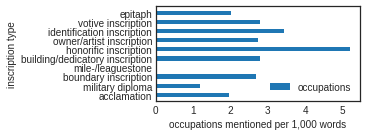

In [33]:
fig, ax  = plt.subplots(figsize=(5.2, 2), tight_layout=True)

y = np.arange(len(types))
height = 0.48

ax.barh(y, occups_freqs, height, label="occupations", color="tab:blue") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations mentioned per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [32]:
save_figure(fig, "LIST_occups_by_inscrtypes")

FileNotFoundError: [Errno 2] No such file or directory: '../figures/LIST_occups_by_inscrtypes.tiff'

## Occupations & organizations together
(not used now...)

In [37]:
len(LIST[LIST["organizations_N"]>0])

1736

In [38]:
len(LIST[LIST["occups_N"]>0])

5745

In [39]:
len(LIST[(LIST["occups_N"]>0) & (LIST["organizations_N"]>0)])

689

In [ ]:
# does not work... see previous versions....
#LIST["occupsorgs"] = LIST.apply(lambda row: eval(row["occups"]) + eval(row["organizations"]), axis=1)

## Occupations & Organizations over centuries

In [40]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

def orgs_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["organizations_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

def orgs_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["organizations_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [ ]:
%%time
occups_counts = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], occups_count)
occups_ins_ratio = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], occups_inscriptions_ratio)
occups_TF_data = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], occups_cumulTF)
unique_occups_data = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], unique_occups)
unique_occups_ratio_data = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], unique_occups_ratio)
unique_occups_ins_ratio_data = tempun.sim_data_by_function(LIST, 100, [-50, 350, 50], unique_occups_ins_ratio)

In [ ]:
sim_data_list = [
    (occups_counts, "(A) occups count", "occups mentions count"),
    (occups_ins_ratio, "(B) occups per 100 inscrs", "occups"),
    (occups_TF_data, "(C) occups per 1000 words", "occups"),
    (unique_occups_data, "(D) unique occups", "unique occups"),
    (unique_occups_ratio_data, "(E) unique occups\nper 1000 unique words", "unique occups"),
    (unique_occups_ins_ratio_data, "(F) unique occups\nper 100 inscrs", "unique occups")
]

In [ ]:
unique_occups_data[0]

In [ ]:
colors_base_list = list(mcolors.BASE_COLORS)

In [ ]:
#plt.style.use("seaborn-white")

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 4), tight_layout=True)
n = 0
for sim_data, ax in zip(sim_data_list, axs.ravel()):
        tempun.plot_timeblocks_data(sim_data[0], ax, "blue", label="occups", alpha=0.8)
        n += 1
        ax.set_title(sim_data[1])
        ax.set_ylabel(sim_data[2])
        if sim_data[1] == "(A) occups count":
            ax.legend(ncol=2, bbox_to_anchor=(0, 1.2), loc="lower left")

In [ ]:
save_figure(fig, "occups_temporal_various_metrics")

In [ ]:
%%time
sim_large  = tempun.timeblocks_from_randoms(LIST[LIST["urban_context_alt"]=="large"], "random_dates", [-50, 350, 50])
sim_medium = tempun.timeblocks_from_randoms(LIST[LIST["urban_context_alt"]=="medium"], "random_dates", [-50, 350, 50])
sim_small =  tempun.timeblocks_from_randoms(LIST[LIST["urban_context_alt"]=="small"], "random_dates", [-50, 350, 50])
sim_rural = tempun.timeblocks_from_randoms(LIST[LIST["urban_context_alt"]=="rural"], "random_dates", [-50, 350, 50])

In [ ]:
def get_occups_per_1000inscr(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    return (occups_N_sum / len(timeblock_df)) * 1000

occups_per_1000inscr_large = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="large"], 1000, [-50, 350, 50], get_occups_per_1000inscr)
occups_per_1000inscr_medium = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="medium"], 1000, [-50, 350, 50], get_occups_per_1000inscr)
occups_per_1000inscr_small = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="small"], 1000, [-50, 350, 50], get_occups_per_1000inscr)
occups_per_1000inscr_rural = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="rural"], 1000, [-50, 350, 50], get_occups_per_1000inscr)

In [ ]:
occups_per_1000inscr = tempun.sim_data_by_function(LIST, 1000, [-50, 350, 50], get_occups_per_1000inscr)

In [ ]:
%%time
labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[5.2, 3.6], tight_layout=True)

# ax1 - timeblocks
tempun.plot_timeblocks_data(sim_large, color="darkred", ax=ax1)
tempun.plot_timeblocks_data(sim_medium, color="darkgreen", ax=ax1)
tempun.plot_timeblocks_data(sim_small, color="darkblue", ax=ax1)
tempun.plot_timeblocks_data(sim_rural, color="purple", ax=ax1)
ax1.set_ylabel("N of inscriptions")
ax1.set_xlim(-50,350)
ax1.xaxis.grid()
ax1.set_xticklabels([])
ax1.set_title("A", x=0.02, y=0.75)

tempun.plot_timeblocks_data(tb_data_large, color="darkred", ax=ax2)
tempun.plot_timeblocks_data(tb_data_medium, color="darkgreen", ax=ax2)
tempun.plot_timeblocks_data(tb_data_small, color="darkblue", ax=ax2)
tempun.plot_timeblocks_data(tb_data_rural, color="purple", ax=ax2)
ax2.set_ylabel("N of occcupations")
ax2.set_xlim(-50,350)
ax2.xaxis.grid()
ax2.set_xticklabels([])
ax2.set_title("B", x=0.02, y=0.75)

tempun.plot_timeblocks_data(occups_per_1000inscr_large, color="darkred", ax=ax3)
tempun.plot_timeblocks_data(occups_per_1000inscr_medium, color="darkgreen", ax=ax3)
tempun.plot_timeblocks_data(occups_per_1000inscr_small, color="darkblue", ax=ax3)
tempun.plot_timeblocks_data(occups_per_1000inscr_rural, color="purple", ax=ax3)
ax3.set_ylabel("N of occcupations\nper 1,000 inscriptions")
ax3.set_xlim(-50,350)
ax3.xaxis.grid()
ax3.set_title("C", x=0.02, y=0.75)

legend_labels=[
    "large cities",
    "medium cities",
    "small cities",
    "rural areas"]

colors=["darkred", "darkgreen", "darkblue", "purple"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax3.legend(markers, legend_labels, numpoints=1,  title="Legend", bbox_to_anchor=(1, 0), loc='lower left')

In [ ]:
save_figure(fig, "occups_vs_inscrs_tempdist_timeblocks")

In [ ]:
def get_bootstrap(df, timeblock, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        dates_var_series = df["random_dates"].apply(lambda x: x[n])
        df_timeblock = df[dates_var_series.between(timeblock[0], timeblock[1])]
        sample_df = df_timeblock.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values


def get_statistics(df, timeblock1, timeblock2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df, timeblock1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df, timeblock2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(
        ((len(df1_values) - 1) * ((np.std(df1_values) ** 2))) + ((len(df2_values) - 1) * (np.std(df2_values) ** 2)) / (
                    len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]


def bootstrap_test(df, timeblock1, timeblock2, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df, timeblock1, timeblock2, 1000, 1000, column, row_function)
    p1 = sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [ ]:
p, cohens_delta, CI95, data = bootstrap_test(LIST[LIST["urban_context_alt"]=="small"], (101,150), (51, 100), "occups_N")
p, cohens_delta

In [ ]:
print(pd.Series(data[0]).describe())
print(pd.Series(data[1]).describe())

In [ ]:
third_century_bootsraps = {}
for context in ["large", "medium", "small", "rural"]:
    p, cohens_delta, CI95, data = bootstrap_test(LIST[LIST["urban_context_alt"] == context], (201, 250), (251, 300),
                                                 "occups_N")
    third_century_bootsraps[context] = {
        "p": p,
        "cohens_delta": cohens_delta,
        "CI95": CI95,
        "data": data}
    print(p, cohens_delta)

## Occupations & organizations by periods

(no used in the current version of the article...)

In [ ]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["occups_N"].sum()
    return occups_N_sum

def orgs_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["organizations_N"].sum()
    return occups_N_sum

In [ ]:
%%time

# time consuming, apply carefully
#occups_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_count) 
occups_ins_ratio = tempun.sim_data_by_function(LIST, 1000, timeblocks_periods, occups_per_1K_ins)

In [ ]:
occups_ins_ratio_large = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="large"], 1000, timeblocks_periods, occups_per_1K_ins)
occups_ins_ratio_medium = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="medium"], 1000, timeblocks_periods, occups_per_1K_ins)
occups_ins_ratio_small = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="small"], 1000, timeblocks_periods, occups_per_1K_ins)
occups_ins_ratio_rural = tempun.sim_data_by_function(LIST[LIST["urban_context_alt"]=="rural"], 1000, timeblocks_periods, occups_per_1K_ins)

In [ ]:
occups_ins_ratio_rome = tempun.sim_data_by_function(LIST_rome, 1000, timeblocks_periods, occups_per_1K_ins)

In [ ]:
occups_ins_ratio[2]

In [ ]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data


occups_ratios_merged = simulations_merged(occups_ins_ratio)

occups_ratios_merged_large = simulations_merged(occups_ins_ratio_large)
occups_ratios_merged_medium = simulations_merged(occups_ins_ratio_medium)
occups_ratios_merged_small = simulations_merged(occups_ins_ratio_small)
occups_ratios_merged_rural = simulations_merged(occups_ins_ratio_rural)

occups_ratios_merged_rome = simulations_merged(occups_ins_ratio_rome)

In [ ]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation. 

labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax1 = plt.subplots(1,1, figsize=[5.2,3], tight_layout=True)

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)

ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 88)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.secondary_xaxis("bottom")
ax1.set_xlim(-50, 350)


# fill with colors
colors =tab_colors_list[:len(labels)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [ ]:
save_figure(fig, "occups_by_periods_bar")

In [ ]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation.

labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1, ax2] = plt.subplots(2,1, figsize=[5.2,4], tight_layout=True)

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)

ax1.set_title("A - all inscriptions")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 100)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
ax1.set_xticks([])
#ax1.secondary_xaxis("bottom")
#ax1.set_xlim(-50, 350)

data2 = [tup[1] for tup in occups_ratios_merged_rome]
means2 = [np.mean(tup[1]) for tup in occups_ratios_merged_rome]

bplot2 = ax2.boxplot(data2, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.plot(positions, means2, color="black", linestyle="dashed", zorder=10)

ax2.set_title("B - rome")
ax2.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax2.set_ylim(0, 100)
ax2.xaxis.tick_top()
ax2.set_xticks([])
ax2.secondary_xaxis("bottom")

ax2.set_xlim(-50, 350)



# fill with colors
colors =tab_colors_list[:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [ ]:
 [np.mean(tup[1]) for tup in occups_ratios_merged_large]

In [ ]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation.

labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=[5.2,5.2], tight_layout=True)

x_title = 0.02
y_title = 0.8
ax1.set_title("A", x=x_title, y=y_title)
ax2.set_title("B", x=x_title, y=y_title)
ax3.set_title("C", x=x_title, y=y_title)
ax4.set_title("D", x=x_title, y=y_title)

# A - large cities
data1 = [tup[1] for tup in occups_ratios_merged_large]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged_large]
bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)

ax1.set_ylabel("N of occups\nper 1,000 inscr.")
ax1.set_ylim(0, 130)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
#ax1.set_xticks([])
#ax1.secondary_xaxis("bottom")
#ax1.set_xlim(-50, 350)

# B - medium cities
data2 = [tup[1] for tup in occups_ratios_merged_medium]
means2 = [np.mean(tup[1]) for tup in occups_ratios_merged_medium]
bplot2 = ax2.boxplot(data2, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.plot(positions, means2, color="black", linestyle="dashed", zorder=10)

ax2.set_ylabel("N of occups\nper 1,000 inscr.")
ax2.set_ylim(0, 100)
ax2.xaxis.tick_top()
ax2.set_xticks([])
#ax2.secondary_xaxis("bottom")
ax2.set_xlim(-50, 350)

# C - small cities
data3 = [tup[1] for tup in occups_ratios_merged_small]
means3 = [np.mean(tup[1]) for tup in occups_ratios_merged_small]

bplot3 = ax3.boxplot(data3, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax3.plot(positions, means3, color="black", linestyle="dashed", zorder=10)

ax3.set_ylabel("N of occups\nper 1,000 inscr.")
ax3.set_ylim(0, 100)
ax3.xaxis.tick_top()
ax3.set_xticks([])
#ax3.secondary_xaxis("bottom")
ax3.set_xlim(-50, 350)

# D - rural areas
data4 = [tup[1] for tup in occups_ratios_merged_rural]
means4 = [np.mean(tup[1]) for tup in occups_ratios_merged_rural]
bplot4 = ax4.boxplot(data4, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax4.plot(positions, means4, color="black", linestyle="dashed", zorder=10)

ax4.set_ylabel("N of occups\nper 1,000 inscr.")
ax4.set_ylim(0, 50)
ax4.xaxis.tick_top()
ax4.set_xticks([])
ax4.secondary_xaxis("bottom")
ax4.set_xlim(-50, 350)


# fill with colors
colors = tab_colors_list[:len(labels)]
for bplot in (bplot1, bplot2, bplot3, bplot4):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [ ]:
# bootstrap test?